In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

import torch
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

from skopt.utils import use_named_args

from xgboost import XGBClassifier, callback
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [19]:
# Load the dataset
file_path = '/kaggle/input/birdclef/preprocessed_data.csv'
df = pd.read_csv(file_path)

# 'Order' is the main target for stratified splitting at the top level
target_column = 'Order'

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[target_column], random_state=42)
# Second split: Temp (30%) into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target_column], random_state=42)


# Print the sizes to verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 8825
Validation set size: 1891
Test set size: 1892


In [20]:
# List of columns to analyze
columns_to_analyze = ['Order']

# Function to analyze each column
def analyze_column(df, column_name):
    print(f"\nColumn: {column_name}")
    
    # Total number of unique values
    unique_values = df[column_name].nunique()
    print(f"Total number of unique values: {unique_values}")
    
    # Number of missing values
    missing_values = df[column_name].isnull().sum()
    print(f"Number of missing values: {missing_values}")
    
    # Count of occurrences for each unique value
    value_counts = df[column_name].value_counts()
    print(f"\nCount of occurrences for each unique value:\n{value_counts}")

# Analyze each column in the list
for column in columns_to_analyze:
    analyze_column(test_df, column)
    


Column: Order
Total number of unique values: 17
Number of missing values: 0

Count of occurrences for each unique value:
Order
8     501
2     442
1     357
6     113
9      95
15     81
13     63
3      59
7      46
0      32
5      31
11     22
12     16
16     14
4      11
10      7
14      2
Name: count, dtype: int64


In [21]:
# Define feature columns
feature_columns = [col for col in df.columns if col.startswith('mfcc') or 
                   col.startswith('chroma') or col.startswith('spectral') or 
                   col in ['zcr_mean', 'x', 'y', 'z']]
target_column = 'Order'

X_train = train_df[feature_columns].values
X_val = val_df[feature_columns].values
X_test = test_df[feature_columns].values

y_train = train_df[target_column].values
y_val = val_df[target_column].values
y_test = test_df[target_column].values

# Perform SMOTE on the training set to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert data to PyTorch tensors directly
train_dataset = TensorDataset(torch.tensor(X_train_smote, dtype=torch.float32), torch.tensor(y_train_smote, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# Load the dataset
file_path = '/kaggle/input/birdclef/extra_preprocessed_data.csv'
df = pd.read_csv(file_path)

# 'Order' is the main target for stratified splitting at the top level
target_column = 'Order'

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[target_column], random_state=42)
# Second split: Temp (30%) into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target_column], random_state=42)


# Print the sizes to verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 8825
Validation set size: 1891
Test set size: 1892


In [21]:
# Define feature columns
feature_columns = [col for col in df.columns if col.startswith('mfcc') or 
                   col.startswith('chroma') or col.startswith('spectral') or
                   col.startswith('zcr') or col.startswith('delta') or 
                   col.startswith('rms') or col in ['x', 'y', 'z' ]]
                                                   
target_column = 'Order'

X_train = train_df[feature_columns].values
X_val = val_df[feature_columns].values
X_test = test_df[feature_columns].values

y_train = train_df[target_column].values
y_val = val_df[target_column].values
y_test = test_df[target_column].values

# Perform SMOTE on the training set to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert data to PyTorch tensors directly
train_dataset = TensorDataset(torch.tensor(X_train_smote, dtype=torch.float32), torch.tensor(y_train_smote, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
# Define the Feedforward Neural Network
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_units, hidden_layers, dropout_rate):
        super(FeedforwardNN, self).__init__()
        layers = [nn.Linear(input_size, hidden_units), nn.ReLU(), nn.Dropout(dropout_rate)]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_units, len(np.unique(y_train))))
        layers.append(nn.LogSoftmax(dim=1))  # For multi-class classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=50, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{n_epochs}, Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save model state
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break


In [24]:
from sklearn.model_selection import GridSearchCV, ParameterGrid


In [25]:
# Define hyperparameter grid
param_grid = {
    'hidden_layers': [2,3,4],
    'hidden_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.3],
}

def evaluate_model(hidden_layers, hidden_units, dropout_rate, learning_rate=0.001):
    model = FeedforwardNN(input_size=X_train_smote.shape[1], hidden_units=hidden_units, hidden_layers=hidden_layers, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=50)

    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluate on validation set for metrics
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

    return macro_f1, balanced_accuracy

# Perform grid search
best_score = 0
best_params = None

for params in ParameterGrid(param_grid):
    macro_f1, balanced_accuracy = evaluate_model(**params)
    print(f"Params: {params} => Macro F1: {macro_f1:.4f}, Balanced Accuracy: {balanced_accuracy:.4f}")
    if macro_f1 > best_score:
        best_score = macro_f1
        best_params = params

print(f"Best Params: {best_params}, Best Macro F1: {best_score:.4f}")


Epoch 1/50, Validation Loss: 2.2568
Epoch 2/50, Validation Loss: 2.0489
Epoch 3/50, Validation Loss: 2.0041
Epoch 4/50, Validation Loss: 1.9112
Epoch 5/50, Validation Loss: 1.8450
Epoch 6/50, Validation Loss: 1.9232
Epoch 7/50, Validation Loss: 1.8473
Epoch 8/50, Validation Loss: 1.7551
Epoch 9/50, Validation Loss: 1.7296
Epoch 10/50, Validation Loss: 1.7575
Epoch 11/50, Validation Loss: 1.7006
Epoch 12/50, Validation Loss: 1.6737
Epoch 13/50, Validation Loss: 1.6128
Epoch 14/50, Validation Loss: 1.6037
Epoch 15/50, Validation Loss: 1.6763
Epoch 16/50, Validation Loss: 1.6841
Epoch 17/50, Validation Loss: 1.6491
Epoch 18/50, Validation Loss: 1.5281
Epoch 19/50, Validation Loss: 1.5616
Epoch 20/50, Validation Loss: 1.5013
Epoch 21/50, Validation Loss: 1.5181
Epoch 22/50, Validation Loss: 1.5169
Epoch 23/50, Validation Loss: 1.5233
Epoch 24/50, Validation Loss: 1.5219
Epoch 25/50, Validation Loss: 1.4894
Epoch 26/50, Validation Loss: 1.4748
Epoch 27/50, Validation Loss: 1.4340
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.0367
Epoch 2/50, Validation Loss: 1.8802
Epoch 3/50, Validation Loss: 1.8863
Epoch 4/50, Validation Loss: 1.6278
Epoch 5/50, Validation Loss: 1.5722
Epoch 6/50, Validation Loss: 1.6630
Epoch 7/50, Validation Loss: 1.4690
Epoch 8/50, Validation Loss: 1.4541
Epoch 9/50, Validation Loss: 1.5130
Epoch 10/50, Validation Loss: 1.4662
Epoch 11/50, Validation Loss: 1.3287
Epoch 12/50, Validation Loss: 1.3674
Epoch 13/50, Validation Loss: 1.4014
Epoch 14/50, Validation Loss: 1.3173
Epoch 15/50, Validation Loss: 1.3671
Epoch 16/50, Validation Loss: 1.4044
Epoch 17/50, Validation Loss: 1.3869
Epoch 18/50, Validation Loss: 1.2695
Epoch 19/50, Validation Loss: 1.3453
Epoch 20/50, Validation Loss: 1.2572
Epoch 21/50, Validation Loss: 1.3106
Epoch 22/50, Validation Loss: 1.2918
Epoch 23/50, Validation Loss: 1.2727
Epoch 24/50, Validation Loss: 1.3232
Epoch 25/50, Validation Loss: 1.2631
Epoch 26/50, Validation Loss: 1.2678
Epoch 27/50, Validation Loss: 1.2096
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 1.9594
Epoch 2/50, Validation Loss: 1.6271
Epoch 3/50, Validation Loss: 1.6255
Epoch 4/50, Validation Loss: 1.5084
Epoch 5/50, Validation Loss: 1.4796
Epoch 6/50, Validation Loss: 1.4003
Epoch 7/50, Validation Loss: 1.3593
Epoch 8/50, Validation Loss: 1.3612
Epoch 9/50, Validation Loss: 1.3684
Epoch 10/50, Validation Loss: 1.3707
Epoch 11/50, Validation Loss: 1.2832
Epoch 12/50, Validation Loss: 1.2792
Epoch 13/50, Validation Loss: 1.2758
Epoch 14/50, Validation Loss: 1.1971
Epoch 15/50, Validation Loss: 1.1985
Epoch 16/50, Validation Loss: 1.2755
Epoch 17/50, Validation Loss: 1.2530
Epoch 18/50, Validation Loss: 1.2367
Epoch 19/50, Validation Loss: 1.2026
Epoch 20/50, Validation Loss: 1.2916
Epoch 21/50, Validation Loss: 1.2038
Epoch 22/50, Validation Loss: 1.2488
Epoch 23/50, Validation Loss: 1.1950
Epoch 24/50, Validation Loss: 1.2126
Epoch 25/50, Validation Loss: 1.2833
Epoch 26/50, Validation Loss: 1.2702
Epoch 27/50, Validation Loss: 1.1853
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.3033
Epoch 2/50, Validation Loss: 2.1075
Epoch 3/50, Validation Loss: 2.0170
Epoch 4/50, Validation Loss: 1.9790
Epoch 5/50, Validation Loss: 1.8264
Epoch 6/50, Validation Loss: 1.9067
Epoch 7/50, Validation Loss: 1.9309
Epoch 8/50, Validation Loss: 1.8278
Epoch 9/50, Validation Loss: 1.7441
Epoch 10/50, Validation Loss: 1.8281
Epoch 11/50, Validation Loss: 1.7543
Epoch 12/50, Validation Loss: 1.8272
Epoch 13/50, Validation Loss: 1.7781
Epoch 14/50, Validation Loss: 1.7812
Epoch 15/50, Validation Loss: 1.7204
Epoch 16/50, Validation Loss: 1.7331
Epoch 17/50, Validation Loss: 1.8218
Epoch 18/50, Validation Loss: 1.7015
Epoch 19/50, Validation Loss: 1.7566
Epoch 20/50, Validation Loss: 1.7498
Epoch 21/50, Validation Loss: 1.7141
Epoch 22/50, Validation Loss: 1.6572
Epoch 23/50, Validation Loss: 1.6286
Epoch 24/50, Validation Loss: 1.6872
Epoch 25/50, Validation Loss: 1.6414
Epoch 26/50, Validation Loss: 1.6703
Epoch 27/50, Validation Loss: 1.6819
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.4028
Epoch 2/50, Validation Loss: 1.8755
Epoch 3/50, Validation Loss: 1.7986
Epoch 4/50, Validation Loss: 1.9627
Epoch 5/50, Validation Loss: 1.7203
Epoch 6/50, Validation Loss: 1.6696
Epoch 7/50, Validation Loss: 1.7025
Epoch 8/50, Validation Loss: 1.5931
Epoch 9/50, Validation Loss: 1.5587
Epoch 10/50, Validation Loss: 1.5533
Epoch 11/50, Validation Loss: 1.4855
Epoch 12/50, Validation Loss: 1.5520
Epoch 13/50, Validation Loss: 1.4737
Epoch 14/50, Validation Loss: 1.3972
Epoch 15/50, Validation Loss: 1.4560
Epoch 16/50, Validation Loss: 1.2883
Epoch 17/50, Validation Loss: 1.4177
Epoch 18/50, Validation Loss: 1.3477
Epoch 19/50, Validation Loss: 1.3616
Epoch 20/50, Validation Loss: 1.3329
Epoch 21/50, Validation Loss: 1.3023
Epoch 22/50, Validation Loss: 1.3620
Epoch 23/50, Validation Loss: 1.3314
Epoch 24/50, Validation Loss: 1.3078
Epoch 25/50, Validation Loss: 1.4124
Epoch 26/50, Validation Loss: 1.3060
Early stopping triggered
Params: {'dropout_rate

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.0728
Epoch 2/50, Validation Loss: 1.9143
Epoch 3/50, Validation Loss: 1.6933
Epoch 4/50, Validation Loss: 1.5019
Epoch 5/50, Validation Loss: 1.4933
Epoch 6/50, Validation Loss: 1.4916
Epoch 7/50, Validation Loss: 1.4890
Epoch 8/50, Validation Loss: 1.4475
Epoch 9/50, Validation Loss: 1.3718
Epoch 10/50, Validation Loss: 1.4152
Epoch 11/50, Validation Loss: 1.3088
Epoch 12/50, Validation Loss: 1.2754
Epoch 13/50, Validation Loss: 1.3171
Epoch 14/50, Validation Loss: 1.3279
Epoch 15/50, Validation Loss: 1.2910
Epoch 16/50, Validation Loss: 1.2377
Epoch 17/50, Validation Loss: 1.2716
Epoch 18/50, Validation Loss: 1.3097
Epoch 19/50, Validation Loss: 1.3341
Epoch 20/50, Validation Loss: 1.2655
Epoch 21/50, Validation Loss: 1.2758
Epoch 22/50, Validation Loss: 1.2642
Epoch 23/50, Validation Loss: 1.2999
Epoch 24/50, Validation Loss: 1.2281
Epoch 25/50, Validation Loss: 1.2259
Epoch 26/50, Validation Loss: 1.1894
Epoch 27/50, Validation Loss: 1.1584
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.4522
Epoch 2/50, Validation Loss: 2.2885
Epoch 3/50, Validation Loss: 2.2456
Epoch 4/50, Validation Loss: 2.1504
Epoch 5/50, Validation Loss: 2.0871
Epoch 6/50, Validation Loss: 2.0156
Epoch 7/50, Validation Loss: 1.9966
Epoch 8/50, Validation Loss: 2.0192
Epoch 9/50, Validation Loss: 1.9623
Epoch 10/50, Validation Loss: 1.9242
Epoch 11/50, Validation Loss: 1.9036
Epoch 12/50, Validation Loss: 1.9437
Epoch 13/50, Validation Loss: 1.9616
Epoch 14/50, Validation Loss: 1.7707
Epoch 15/50, Validation Loss: 1.9021
Epoch 16/50, Validation Loss: 1.8004
Epoch 17/50, Validation Loss: 1.8005
Epoch 18/50, Validation Loss: 1.7398
Epoch 19/50, Validation Loss: 1.7593
Epoch 20/50, Validation Loss: 1.7906
Epoch 21/50, Validation Loss: 1.7875
Epoch 22/50, Validation Loss: 1.7782
Epoch 23/50, Validation Loss: 1.8342
Epoch 24/50, Validation Loss: 1.7920
Epoch 25/50, Validation Loss: 1.6886
Epoch 26/50, Validation Loss: 1.7085
Epoch 27/50, Validation Loss: 1.8758
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.3795
Epoch 2/50, Validation Loss: 2.2044
Epoch 3/50, Validation Loss: 1.9584
Epoch 4/50, Validation Loss: 1.8827
Epoch 5/50, Validation Loss: 1.9394
Epoch 6/50, Validation Loss: 1.8834
Epoch 7/50, Validation Loss: 1.7701
Epoch 8/50, Validation Loss: 1.6406
Epoch 9/50, Validation Loss: 1.7384
Epoch 10/50, Validation Loss: 1.5636
Epoch 11/50, Validation Loss: 1.6444
Epoch 12/50, Validation Loss: 1.5751
Epoch 13/50, Validation Loss: 1.5402
Epoch 14/50, Validation Loss: 1.6191
Epoch 15/50, Validation Loss: 1.5151
Epoch 16/50, Validation Loss: 1.5037
Epoch 17/50, Validation Loss: 1.5263
Epoch 18/50, Validation Loss: 1.4471
Epoch 19/50, Validation Loss: 1.5461
Epoch 20/50, Validation Loss: 1.4904
Epoch 21/50, Validation Loss: 1.4450
Epoch 22/50, Validation Loss: 1.4642
Epoch 23/50, Validation Loss: 1.4627
Epoch 24/50, Validation Loss: 1.4431
Epoch 25/50, Validation Loss: 1.6118
Epoch 26/50, Validation Loss: 1.3823
Epoch 27/50, Validation Loss: 1.4902
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.2067
Epoch 2/50, Validation Loss: 2.0340
Epoch 3/50, Validation Loss: 1.8092
Epoch 4/50, Validation Loss: 1.6646
Epoch 5/50, Validation Loss: 1.8203
Epoch 6/50, Validation Loss: 1.6030
Epoch 7/50, Validation Loss: 1.5010
Epoch 8/50, Validation Loss: 1.4549
Epoch 9/50, Validation Loss: 1.5172
Epoch 10/50, Validation Loss: 1.5052
Epoch 11/50, Validation Loss: 1.4591
Epoch 12/50, Validation Loss: 1.5823
Epoch 13/50, Validation Loss: 1.3914
Epoch 14/50, Validation Loss: 1.3940
Epoch 15/50, Validation Loss: 1.3214
Epoch 16/50, Validation Loss: 1.3576
Epoch 17/50, Validation Loss: 1.2680
Epoch 18/50, Validation Loss: 1.3562
Epoch 19/50, Validation Loss: 1.2653
Epoch 20/50, Validation Loss: 1.2461
Epoch 21/50, Validation Loss: 1.3460
Epoch 22/50, Validation Loss: 1.2794
Epoch 23/50, Validation Loss: 1.2447
Epoch 24/50, Validation Loss: 1.3210
Epoch 25/50, Validation Loss: 1.2839
Epoch 26/50, Validation Loss: 1.3595
Epoch 27/50, Validation Loss: 1.3768
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.3738
Epoch 2/50, Validation Loss: 2.2776
Epoch 3/50, Validation Loss: 2.0708
Epoch 4/50, Validation Loss: 1.9364
Epoch 5/50, Validation Loss: 2.0378
Epoch 6/50, Validation Loss: 1.9546
Epoch 7/50, Validation Loss: 1.9158
Epoch 8/50, Validation Loss: 1.8495
Epoch 9/50, Validation Loss: 1.7887
Epoch 10/50, Validation Loss: 1.8911
Epoch 11/50, Validation Loss: 1.7892
Epoch 12/50, Validation Loss: 1.7800
Epoch 13/50, Validation Loss: 1.8975
Epoch 14/50, Validation Loss: 1.7799
Epoch 15/50, Validation Loss: 1.8774
Epoch 16/50, Validation Loss: 1.8029
Epoch 17/50, Validation Loss: 1.8210
Epoch 18/50, Validation Loss: 1.7416
Epoch 19/50, Validation Loss: 1.6754
Epoch 20/50, Validation Loss: 1.7382
Epoch 21/50, Validation Loss: 1.7422
Epoch 22/50, Validation Loss: 1.7254
Epoch 23/50, Validation Loss: 1.6539
Epoch 24/50, Validation Loss: 1.7238
Epoch 25/50, Validation Loss: 1.6745
Epoch 26/50, Validation Loss: 1.6490
Epoch 27/50, Validation Loss: 1.6798
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.2942
Epoch 2/50, Validation Loss: 1.9869
Epoch 3/50, Validation Loss: 1.9291
Epoch 4/50, Validation Loss: 1.7442
Epoch 5/50, Validation Loss: 1.7107
Epoch 6/50, Validation Loss: 1.6630
Epoch 7/50, Validation Loss: 1.7521
Epoch 8/50, Validation Loss: 1.5944
Epoch 9/50, Validation Loss: 1.5113
Epoch 10/50, Validation Loss: 1.4996
Epoch 11/50, Validation Loss: 1.4814
Epoch 12/50, Validation Loss: 1.5280
Epoch 13/50, Validation Loss: 1.5232
Epoch 14/50, Validation Loss: 1.4548
Epoch 15/50, Validation Loss: 1.3897
Epoch 16/50, Validation Loss: 1.4436
Epoch 17/50, Validation Loss: 1.4235
Epoch 18/50, Validation Loss: 1.3931
Epoch 19/50, Validation Loss: 1.4594
Epoch 20/50, Validation Loss: 1.3563
Epoch 21/50, Validation Loss: 1.4162
Epoch 22/50, Validation Loss: 1.4092
Epoch 23/50, Validation Loss: 1.3309
Epoch 24/50, Validation Loss: 1.3098
Epoch 25/50, Validation Loss: 1.3819
Epoch 26/50, Validation Loss: 1.3622
Epoch 27/50, Validation Loss: 1.3532
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.0849
Epoch 2/50, Validation Loss: 1.7247
Epoch 3/50, Validation Loss: 1.6091
Epoch 4/50, Validation Loss: 1.5617
Epoch 5/50, Validation Loss: 1.4660
Epoch 6/50, Validation Loss: 1.7109
Epoch 7/50, Validation Loss: 1.3607
Epoch 8/50, Validation Loss: 1.3398
Epoch 9/50, Validation Loss: 1.3196
Epoch 10/50, Validation Loss: 1.3849
Epoch 11/50, Validation Loss: 1.3148
Epoch 12/50, Validation Loss: 1.3035
Epoch 13/50, Validation Loss: 1.3057
Epoch 14/50, Validation Loss: 1.2693
Epoch 15/50, Validation Loss: 1.3302
Epoch 16/50, Validation Loss: 1.2477
Epoch 17/50, Validation Loss: 1.1844
Epoch 18/50, Validation Loss: 1.2878
Epoch 19/50, Validation Loss: 1.1861
Epoch 20/50, Validation Loss: 1.3293
Epoch 21/50, Validation Loss: 1.2146
Epoch 22/50, Validation Loss: 1.2138
Epoch 23/50, Validation Loss: 1.1658
Epoch 24/50, Validation Loss: 1.2077
Epoch 25/50, Validation Loss: 1.2755
Epoch 26/50, Validation Loss: 1.2054
Epoch 27/50, Validation Loss: 1.2105
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.4107
Epoch 2/50, Validation Loss: 2.2644
Epoch 3/50, Validation Loss: 2.2023
Epoch 4/50, Validation Loss: 2.1532
Epoch 5/50, Validation Loss: 2.1237
Epoch 6/50, Validation Loss: 2.0170
Epoch 7/50, Validation Loss: 2.0676
Epoch 8/50, Validation Loss: 1.9481
Epoch 9/50, Validation Loss: 1.9326
Epoch 10/50, Validation Loss: 1.9828
Epoch 11/50, Validation Loss: 1.9318
Epoch 12/50, Validation Loss: 1.9037
Epoch 13/50, Validation Loss: 1.9620
Epoch 14/50, Validation Loss: 1.9293
Epoch 15/50, Validation Loss: 1.9617
Epoch 16/50, Validation Loss: 1.8742
Epoch 17/50, Validation Loss: 1.8904
Epoch 18/50, Validation Loss: 1.8993
Epoch 19/50, Validation Loss: 1.8173
Epoch 20/50, Validation Loss: 1.8661
Epoch 21/50, Validation Loss: 1.8620
Epoch 22/50, Validation Loss: 1.8428
Epoch 23/50, Validation Loss: 1.8600
Epoch 24/50, Validation Loss: 1.7848
Epoch 25/50, Validation Loss: 1.8340
Epoch 26/50, Validation Loss: 1.7863
Epoch 27/50, Validation Loss: 1.8067
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.3041
Epoch 2/50, Validation Loss: 2.2301
Epoch 3/50, Validation Loss: 2.0261
Epoch 4/50, Validation Loss: 1.9205
Epoch 5/50, Validation Loss: 1.9311
Epoch 6/50, Validation Loss: 1.7810
Epoch 7/50, Validation Loss: 1.8552
Epoch 8/50, Validation Loss: 1.6940
Epoch 9/50, Validation Loss: 1.6830
Epoch 10/50, Validation Loss: 1.7640
Epoch 11/50, Validation Loss: 1.7098
Epoch 12/50, Validation Loss: 1.6843
Epoch 13/50, Validation Loss: 1.5576
Epoch 14/50, Validation Loss: 1.6462
Epoch 15/50, Validation Loss: 1.6551
Epoch 16/50, Validation Loss: 1.5334
Epoch 17/50, Validation Loss: 1.6349
Epoch 18/50, Validation Loss: 1.6263
Epoch 19/50, Validation Loss: 1.5080
Epoch 20/50, Validation Loss: 1.5400
Epoch 21/50, Validation Loss: 1.5053
Epoch 22/50, Validation Loss: 1.5513
Epoch 23/50, Validation Loss: 1.5046
Epoch 24/50, Validation Loss: 1.4504
Epoch 25/50, Validation Loss: 1.6117
Epoch 26/50, Validation Loss: 1.5292
Epoch 27/50, Validation Loss: 1.4548
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.1832
Epoch 2/50, Validation Loss: 1.8451
Epoch 3/50, Validation Loss: 1.8319
Epoch 4/50, Validation Loss: 1.7498
Epoch 5/50, Validation Loss: 1.6932
Epoch 6/50, Validation Loss: 1.6511
Epoch 7/50, Validation Loss: 1.5155
Epoch 8/50, Validation Loss: 1.5767
Epoch 9/50, Validation Loss: 1.5554
Epoch 10/50, Validation Loss: 1.5000
Epoch 11/50, Validation Loss: 1.4910
Epoch 12/50, Validation Loss: 1.4535
Epoch 13/50, Validation Loss: 1.3943
Epoch 14/50, Validation Loss: 1.4486
Epoch 15/50, Validation Loss: 1.3329
Epoch 16/50, Validation Loss: 1.4217
Epoch 17/50, Validation Loss: 1.2750
Epoch 18/50, Validation Loss: 1.3699
Epoch 19/50, Validation Loss: 1.3888
Epoch 20/50, Validation Loss: 1.3091
Epoch 21/50, Validation Loss: 1.3143
Epoch 22/50, Validation Loss: 1.2888
Epoch 23/50, Validation Loss: 1.3048
Epoch 24/50, Validation Loss: 1.2419
Epoch 25/50, Validation Loss: 1.2506
Epoch 26/50, Validation Loss: 1.3158
Epoch 27/50, Validation Loss: 1.3658
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.4504
Epoch 2/50, Validation Loss: 2.3562
Epoch 3/50, Validation Loss: 2.3205
Epoch 4/50, Validation Loss: 2.3650
Epoch 5/50, Validation Loss: 2.2803
Epoch 6/50, Validation Loss: 2.3443
Epoch 7/50, Validation Loss: 2.1844
Epoch 8/50, Validation Loss: 2.1219
Epoch 9/50, Validation Loss: 2.1781
Epoch 10/50, Validation Loss: 2.1514
Epoch 11/50, Validation Loss: 2.2401
Epoch 12/50, Validation Loss: 2.1579
Epoch 13/50, Validation Loss: 2.1639
Epoch 14/50, Validation Loss: 2.2780
Epoch 15/50, Validation Loss: 2.0730
Epoch 16/50, Validation Loss: 2.1100
Epoch 17/50, Validation Loss: 2.0987
Epoch 18/50, Validation Loss: 2.1151
Epoch 19/50, Validation Loss: 2.0728
Epoch 20/50, Validation Loss: 2.0637
Epoch 21/50, Validation Loss: 2.0760
Epoch 22/50, Validation Loss: 2.0802
Epoch 23/50, Validation Loss: 2.0977
Epoch 24/50, Validation Loss: 2.0714
Epoch 25/50, Validation Loss: 2.0567
Epoch 26/50, Validation Loss: 2.0044
Epoch 27/50, Validation Loss: 2.0311
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.5073
Epoch 2/50, Validation Loss: 2.2222
Epoch 3/50, Validation Loss: 2.2225
Epoch 4/50, Validation Loss: 2.0471
Epoch 5/50, Validation Loss: 2.1895
Epoch 6/50, Validation Loss: 2.1928
Epoch 7/50, Validation Loss: 2.0094
Epoch 8/50, Validation Loss: 1.9727
Epoch 9/50, Validation Loss: 1.9823
Epoch 10/50, Validation Loss: 1.8315
Epoch 11/50, Validation Loss: 1.8381
Epoch 12/50, Validation Loss: 1.7809
Epoch 13/50, Validation Loss: 1.8490
Epoch 14/50, Validation Loss: 1.8047
Epoch 15/50, Validation Loss: 1.8194
Epoch 16/50, Validation Loss: 1.7410
Epoch 17/50, Validation Loss: 1.7704
Epoch 18/50, Validation Loss: 1.7544
Epoch 19/50, Validation Loss: 1.8179
Epoch 20/50, Validation Loss: 1.7772
Epoch 21/50, Validation Loss: 1.6987
Epoch 22/50, Validation Loss: 1.6901
Epoch 23/50, Validation Loss: 1.6994
Epoch 24/50, Validation Loss: 1.6752
Epoch 25/50, Validation Loss: 1.6656
Epoch 26/50, Validation Loss: 1.7035
Epoch 27/50, Validation Loss: 1.7620
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.3990
Epoch 2/50, Validation Loss: 2.2025
Epoch 3/50, Validation Loss: 1.9192
Epoch 4/50, Validation Loss: 1.9744
Epoch 5/50, Validation Loss: 1.8394
Epoch 6/50, Validation Loss: 1.7404
Epoch 7/50, Validation Loss: 1.8256
Epoch 8/50, Validation Loss: 1.7470
Epoch 9/50, Validation Loss: 1.6785
Epoch 10/50, Validation Loss: 1.5480
Epoch 11/50, Validation Loss: 1.5106
Epoch 12/50, Validation Loss: 1.4981
Epoch 13/50, Validation Loss: 1.6429
Epoch 14/50, Validation Loss: 1.5835
Epoch 15/50, Validation Loss: 1.5015
Epoch 16/50, Validation Loss: 1.5484
Epoch 17/50, Validation Loss: 1.5628
Epoch 18/50, Validation Loss: 1.5306
Epoch 19/50, Validation Loss: 1.4112
Epoch 20/50, Validation Loss: 1.4430
Epoch 21/50, Validation Loss: 1.4807
Epoch 22/50, Validation Loss: 1.6277
Epoch 23/50, Validation Loss: 1.4230
Epoch 24/50, Validation Loss: 1.4492
Epoch 25/50, Validation Loss: 1.4085
Epoch 26/50, Validation Loss: 1.4642
Epoch 27/50, Validation Loss: 1.4278
Epoch 28/5

/tmp/ipykernel_30/3298735484.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [26]:
# Create the final model with the best parameters
final_model = FeedforwardNN(input_size=X_train_smote.shape[1],
                             hidden_units=best_params['hidden_units'],
                             hidden_layers=best_params['hidden_layers'],
                             dropout_rate=best_params['dropout_rate'])

optimizer = optim.Adam(final_model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# Train the model on the full training data
train_model(final_model, train_loader, val_loader, criterion, optimizer, n_epochs=50)

# Load the best model
final_model.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Validation Loss: 2.0071
Epoch 2/50, Validation Loss: 1.7313
Epoch 3/50, Validation Loss: 1.6431
Epoch 4/50, Validation Loss: 1.6015
Epoch 5/50, Validation Loss: 1.5435
Epoch 6/50, Validation Loss: 1.4411
Epoch 7/50, Validation Loss: 1.5795
Epoch 8/50, Validation Loss: 1.3760
Epoch 9/50, Validation Loss: 1.4639
Epoch 10/50, Validation Loss: 1.3456
Epoch 11/50, Validation Loss: 1.3731
Epoch 12/50, Validation Loss: 1.2503
Epoch 13/50, Validation Loss: 1.4271
Epoch 14/50, Validation Loss: 1.3396
Epoch 15/50, Validation Loss: 1.2960
Epoch 16/50, Validation Loss: 1.3350
Epoch 17/50, Validation Loss: 1.2916
Epoch 18/50, Validation Loss: 1.3169
Epoch 19/50, Validation Loss: 1.2879
Epoch 20/50, Validation Loss: 1.2805
Epoch 21/50, Validation Loss: 1.2022
Epoch 22/50, Validation Loss: 1.2481
Epoch 23/50, Validation Loss: 1.2861
Epoch 24/50, Validation Loss: 1.2633
Epoch 25/50, Validation Loss: 1.2399
Epoch 26/50, Validation Loss: 1.1832
Epoch 27/50, Validation Loss: 1.2409
Epoch 28/5

/tmp/ipykernel_30/430447587.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [27]:
# Define test function to calculate macro F1 and balanced accuracy
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

    print(f"Test Macro F1 Score: {macro_f1:.4f}")
    print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")

# Test the model
test_model(final_model, test_loader)


Test Macro F1 Score: 0.6056
Test Balanced Accuracy: 0.7241


In [31]:
# Define test function to calculate macro F1 and balanced accuracy
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

    print(f"Test Macro F1 Score: {macro_f1:.4f}")
    print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")

# Test the model
test_model(final_model, test_loader)


Test Macro F1 Score: 0.4049
Test Balanced Accuracy: 0.5668


In [5]:
# Load the dataset
file_path = '/kaggle/input/birdclef/extra_preprocessed_data.csv'
df = pd.read_csv(file_path)

# 'Order' is the main target for stratified splitting at the top level
target_column = 'Order'

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[target_column], random_state=42)
# Second split: Temp (30%) into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target_column], random_state=42)


# Print the sizes to verify the splits
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 8825
Validation set size: 1891
Test set size: 1892


In [6]:
# List of columns to analyze
columns_to_analyze = ['Order']

# Function to analyze each column
def analyze_column(df, column_name):
    print(f"\nColumn: {column_name}")
    
    # Total number of unique values
    unique_values = df[column_name].nunique()
    print(f"Total number of unique values: {unique_values}")
    
    # Number of missing values
    missing_values = df[column_name].isnull().sum()
    print(f"Number of missing values: {missing_values}")
    
    # Count of occurrences for each unique value
    value_counts = df[column_name].value_counts()
    print(f"\nCount of occurrences for each unique value:\n{value_counts}")

# Analyze each column in the list
for column in columns_to_analyze:
    analyze_column(test_df, column)
    


Column: Order
Total number of unique values: 17
Number of missing values: 0

Count of occurrences for each unique value:
Order
8     501
2     442
1     357
6     113
9      95
15     81
13     63
3      59
7      46
0      32
5      31
11     22
12     16
16     14
4      11
10      7
14      2
Name: count, dtype: int64


In [7]:
# Define feature columns
feature_columns = [col for col in df.columns if col.startswith('mfcc') or 
                   col.startswith('chroma') or col.startswith('spectral') or
                   col.startswith('zcr') or col.startswith('delta') or 
                   col.startswith('rms') or col in ['x', 'y', 'z' ]]
                                                   
target_column = 'Order'

X_train = train_df[feature_columns].values
X_val = val_df[feature_columns].values
X_test = test_df[feature_columns].values

y_train = train_df[target_column].values
y_val = val_df[target_column].values
y_test = test_df[target_column].values

# Perform SMOTE on the training set to balance classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert data to PyTorch tensors directly
train_dataset = TensorDataset(torch.tensor(X_train_smote, dtype=torch.float32), torch.tensor(y_train_smote, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# Define the Feedforward Neural Network
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x


In [16]:
# Hyperparameters
input_size = len(feature_columns)  # Number of features in your data
hidden_size1 = 256
hidden_size2 =128
hidden_size3 = 64
output_size = 17  # Number of classes
num_epochs = 20


In [17]:
# Initialize the model, loss function, and optimizer
model = FNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
# Training loop
def train_model(model, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, num_epochs)


Epoch [1/20], Train Loss: 1.8080, Validation Loss: 1.9590, Validation Accuracy: 33.42%
Epoch [2/20], Train Loss: 1.2281, Validation Loss: 1.6646, Validation Accuracy: 40.19%
Epoch [3/20], Train Loss: 1.0369, Validation Loss: 1.7048, Validation Accuracy: 41.88%
Epoch [4/20], Train Loss: 0.9081, Validation Loss: 1.5775, Validation Accuracy: 46.91%
Epoch [5/20], Train Loss: 0.8216, Validation Loss: 1.5445, Validation Accuracy: 46.85%
Epoch [6/20], Train Loss: 0.7463, Validation Loss: 1.4795, Validation Accuracy: 50.13%
Epoch [7/20], Train Loss: 0.6844, Validation Loss: 1.3082, Validation Accuracy: 54.94%
Epoch [8/20], Train Loss: 0.6356, Validation Loss: 1.3041, Validation Accuracy: 55.90%
Epoch [9/20], Train Loss: 0.5921, Validation Loss: 1.3865, Validation Accuracy: 55.10%
Epoch [10/20], Train Loss: 0.5439, Validation Loss: 1.2805, Validation Accuracy: 59.18%
Epoch [11/20], Train Loss: 0.5194, Validation Loss: 1.2104, Validation Accuracy: 61.34%
Epoch [12/20], Train Loss: 0.4845, Valida

Test Macro F1 Score: 0.5679
Test Balanced Accuracy: 0.6690
Test ROC AUC: 0.9470


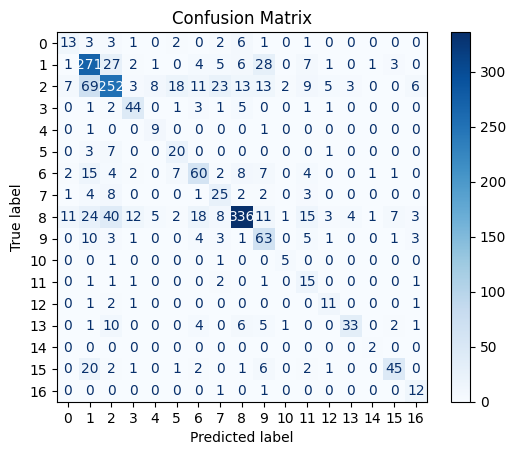

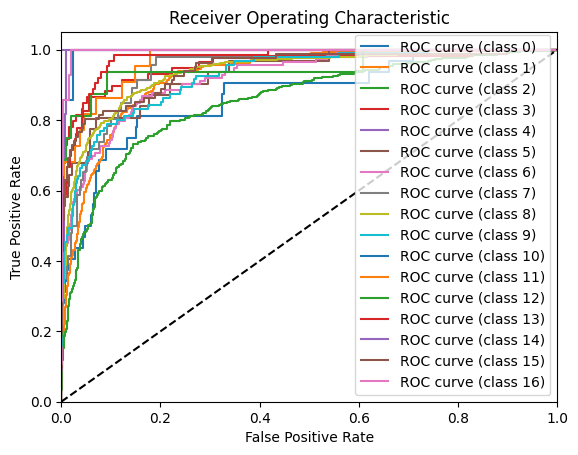

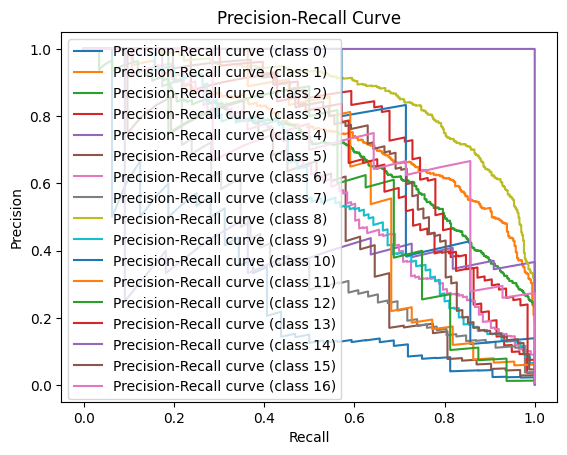

In [19]:
from sklearn.metrics import average_precision_score

def test_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
            all_probs.extend(probs.numpy())

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate metrics
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)
    
    # Compute ROC AUC for multi-class
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    
    # Calculate average precision for multi-class
    #avg_precision = average_precision_score(all_labels, all_probs, average='macro', multi_class='ovr')

    print(f"Test Macro F1 Score: {macro_f1:.4f}")
    print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    #print(f"Test Average Precision: {avg_precision:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    plt.figure()
    for i in range(len(np.unique(all_labels))):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve (class {i})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure()
    for i in range(len(np.unique(all_labels))):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
        plt.plot(recall, precision, label=f'Precision-Recall curve (class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

# Test the model
test_model(model, test_loader)


Test Macro F1 Score: 0.2478
Test Balanced Accuracy: 0.2387
Test ROC AUC: 0.8713


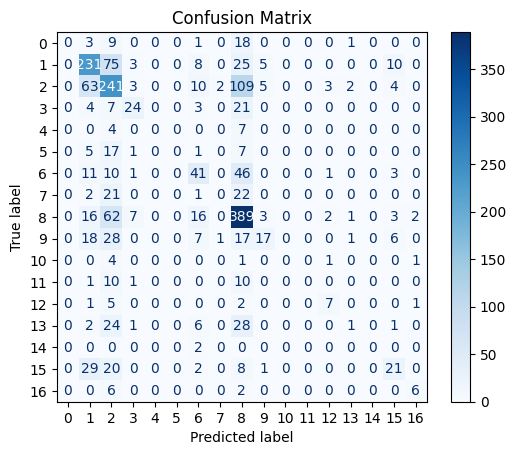

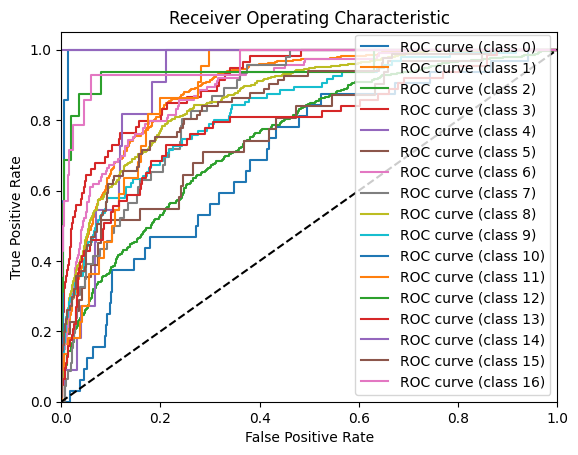

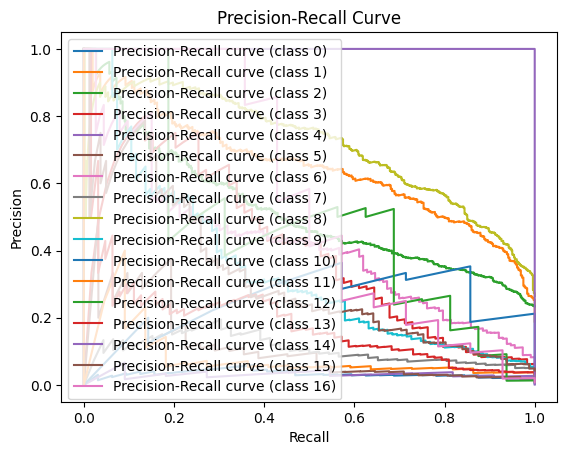

In [12]:
def test_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())
            all_probs.extend(probs.numpy())

    # Convert lists to NumPy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate metrics
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    balanced_accuracy = balanced_accuracy_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    #avg_precision = average_precision_score(all_labels, all_probs, average='macro')
    
    print(f"Test Macro F1 Score: {macro_f1:.4f}")
    print(f"Test Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    #print(f"Test Average Precision: {avg_precision:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    plt.figure()
    for i in range(len(np.unique(all_labels))):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve (class {i})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall curve
    plt.figure()
    for i in range(len(np.unique(all_labels))):
        precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
        plt.plot(recall, precision, label=f'Precision-Recall curve (class {i})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="best")
    plt.show()

# Test the model
test_model(model, test_loader)
